In [ ]:
!pip install git+https://github.com/DeepTrackAI/deeplay

# MNIST digits generation with conditional DDPM

We'll build a conditional variant of denoising diffusion probabilistic model (DDPM) to generate user specified hand-written digits from the MNIST dataset.

## The MNIST dataset

The MNIST dataset consists of grayscale images of hand-written digits from 0 to 9. Each image is 28 pixels by 28 pixels. There're 60,000 training images and 10,000 test images.

We will download the dataset from the `torchvision` package of PyTorch. 

Before downloading the dataset, we will define the normalization that we will apply to the dataset through `torchvision.transforms` module. We will normalize the images to have pixel values between -1 and 1, which is a common practice for training ddpm models.

In [1]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5], inplace=True), # Normalize all images to [-1, 1]
])

We will apply the transforms created above to the training and test MNIST datasets.

The training and test datasets will be downloaded from the `torchvision.datasets` module, into the directory specified by the `root` argument. The `train` argument specifies whether to download the training or the test dataset by setting it to `True` or `False` respectively. Here, we will download the training dataset.

The `transform` argument specifies the transforms to be applied to the dataset. We will pass the transforms created above to this argument.

Set the `download` argument to `True` to download the dataset.

In [2]:
from torchvision.datasets import MNIST

trainset = MNIST(root="data", train=True, transform=transform, download=True)
valset = MNIST(root="data", train=False, transform=transform, download=True)

We can now visualize some images from the training dataset using the `matplotlib` package.

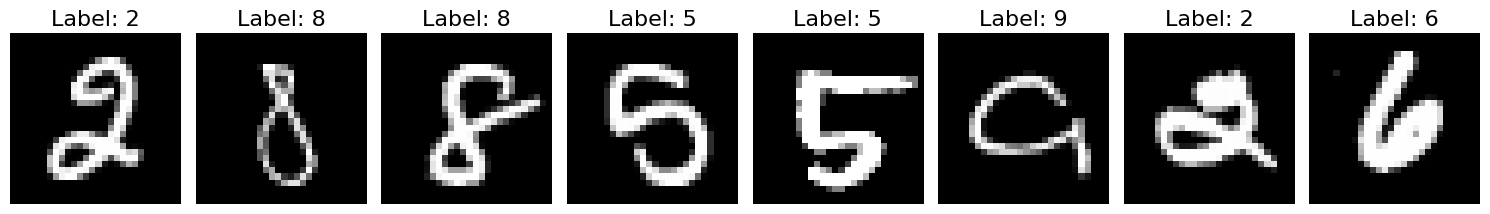

In [3]:
import torch
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 8, figsize=(15, 3))
for ax in axs.ravel():
	img, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()] # randomly select an image from the training set
	ax.imshow(img.squeeze(), cmap="gray")
	ax.set_title(f"Label: {label}", fontsize=16)
	ax.axis("off")
plt.tight_layout()
plt.show()

We now define the `device` to be used for training the model. We will use the GPU if it's available, otherwise we will use the CPU. The `torch.cuda.is_available()` function returns `True` if the GPU is available, otherwise it returns `False`.

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
print(device)

cuda


## Diffusion process

In this section we will implement the forward and the reverse diffusion processes by defining the `Diffusion` class.

We define the `Diffusion` class with the following methods:
1. `prepare_noise_schedule`: Prepares the noise schedule based on the given `beta_start` and `beta_end` parameters, and the number of steps given by the parameter `noise_steps`.
2. `noise_images`: Implements the forward diffusion process. Given an input image `x`, and the time step `t`, it returns the noisy image `x_t`.
3. `sample_timesteps`: Generates `n` random time steps. This is used during the training process to generate a batch of random time steps for the forward diffusion process.
4. `sample_test_image`: Implements the reverse diffusion process. Generates an image from pure noise.

We will add additional attributes to the `sample_test_image` method to allow for conditional generation of images. This will allow us to generate images of a specific digit. The newly added attributes are: `class_labels`, `cfg`, and `cfg_guidance_strength`. The term `cfg` stands for classifer-free guidance which is an approach for class conditioned generation in DDPM models.

In [6]:
from tqdm import tqdm

class Diffusion:
    def __init__(
        self,
        noise_steps=1000,
        beta_start=1e-4,
        beta_end=0.02,
        img_size=256,
        device="cuda:0" if torch.cuda.is_available() else "cpu",
    ):
        """
		Parameters
		----------
		noise_steps : int, optional
			Number of steps in the diffusion process, by default 1000
		beta_start : float, optional
			Starting value of the variance schedule $\beta_t$, by default 1e-4
		beta_end : float, optional
			Ending value of the variance schedule $\beta_t$, by default 0.02
		img_size : int, optional
			Size of the image, by default 256
		device : str, optional
			Device to use for the computations, by default "cuda:0" if torch.cuda.is_available() else "cpu"
        """
        self.noise_steps = noise_steps
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(
            device
        )  # This will create a list of betas from beta_start to beta_end using the prepare_noise_schedule function
        self.alpha = 1.0 - self.beta  # This will create the list of alphas
        self.alpha_bar = torch.cumprod(
            self.alpha, dim=0
        )  # This will create a list of alpha_bars

    def prepare_noise_schedule(self):
        return torch.linspace(
            self.beta_start, self.beta_end, self.noise_steps
        )  # linear schedule

    def noise_images(self, x, t):
        sqrt_alpha_bar = torch.sqrt(self.alpha_bar[t])[:, None, None, None]
        sqrt_one_minus_alpha_bar = torch.sqrt(1 - self.alpha_bar[t])[
            :, None, None, None
        ]
        noise = torch.randn_like(x)

        return sqrt_alpha_bar * x + sqrt_one_minus_alpha_bar * noise, noise

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,)).to(self.device)

    def sample_test_images(
        self,
        model,
        n,  # Number of images to sample
        n_channels,  # Number of channels in the image
        position_encoding_dim,  # Dimension of the positional encoding
        position_encoding_function,  # Positional encoding function
        fixed_noise=None,
        save_time_steps=None,
        save_every=200,  # Store the denoised images every "save_every" steps
        class_labels=None, 
        cfg=False, 
        cfg_guidance_strength=3, 
    ):
        with torch.no_grad():
            denoised_images = []
            if fixed_noise is not None:
                x = fixed_noise.to(self.device)
            else:
                x = torch.randn((n, n_channels, self.img_size, self.img_size)).to(
                    self.device
                )

            for i in tqdm(
                reversed(range(1, self.noise_steps)),
                desc="UNet inference",
                total=self.noise_steps,
            ):
                t = (torch.ones(n) * i).long()
                t_expdims = position_encoding_function(t.unsqueeze(1), position_encoding_dim).to(self.device)

                if cfg:
                    conditional_prediction = model(x, t_expdims, class_labels)
                    unconditional_prediction = model(x, t_expdims, None)
                    predicted_noise = torch.lerp(
                        unconditional_prediction,
                        conditional_prediction,
                        cfg_guidance_strength,
                    )
                else:
                    predicted_noise = model(x, t_expdims, y=class_labels)
                alpha = self.alpha[t][:, None, None, None]
                alpha_bar = self.alpha_bar[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]
                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)
                x = (
                    1
                    / torch.sqrt(alpha)
                    * (
                        x
                        - ((1 - alpha) / (torch.sqrt(1 - alpha_bar))) * predicted_noise
                    )
                    + torch.sqrt(beta) * noise
                )

                # Store the denoised images every "save_every" steps
                if save_time_steps is not None:
                    if i in save_time_steps:
                        denoised_images.append(x)
                else:
                    if i % save_every == 1:
                        denoised_images.append(x)

            # Convert denoised_images to tensor and swap axes (for plotting)
            denoised_images = torch.stack(denoised_images)
            denoised_images = denoised_images.swapaxes(0, 1)
            return denoised_images


We will now define an instance of the `Diffusion` class to generate the images in the forward diffusion process.

In [7]:
diffusion = Diffusion(
	noise_steps=401,
	beta_start=0.0001,
	beta_end=0.02,
	img_size=28, # MNIST images are 28x28
)

We will sample a random image from the training dataset and generate noise images at different time steps.

In [8]:
clean_image, label = trainset[torch.randint(0, len(trainset), (1,)).squeeze()]

time_steps = [0, 100, 200, 300, 400]

noisy_images = []
for i in range(len(time_steps)):
	noisy_image, noise = diffusion.noise_images(
		x=clean_image[None, ...].to(device), t=torch.tensor([time_steps[i]]).to(device)
	)
	noisy_images.append(noisy_image)

We can now visualize the forward diffusion process for the sampled image.

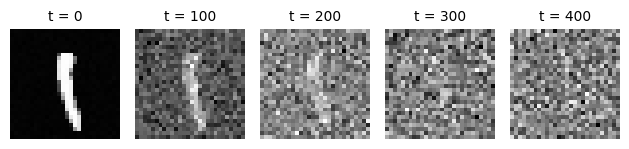

In [9]:
fig, axs = plt.subplots(1, len(time_steps))
for i, ax in enumerate(axs.flatten()):
	ax.imshow(noisy_images[i].cpu().numpy().squeeze(), cmap="gray")
	ax.set_title(f"t = {time_steps[i]}", fontsize=10)
	ax.axis("off")
plt.tight_layout()
plt.show()

## Attention UNet

In this section we will define the Attention UNet that is used in the DDPM model.

We use the class `AttentionUNet` from deeplay to define the Attention UNet architecture. It takes the noisy image and the time step corresponding to the noisy image as input, and returns the noise added to the image as output.

The input channels and output channels are defined the parameters `in_channels` and `out_channels` respectively. The `channels` parameter defines the number of channels in the hidden layers of the UNet, i.e., the number of convolutional filters in the hidden layers.

The `base_channels` parameter defines the number of channels at the base of the UNet, between the encoder and the decoder.

The `channel_attention` parameter can be used to control of attention mechanism that is applied at hidden channels. The boolean values (True or False) defined by the `channel_attention` parameter are used to control the attention mechanism. The first boolean value will be ignored as the time step attention is not included in the first hidden channel. When performing an ablation study, set the attention mechanism to `False` from the end of the list.

The `position_embedding_dim` parameter is used to indicate the dimension of the position encoding of the time step. We will look at it in more detail in the next step.

We will also include a new parameter `num_classes` for the class conditioned generation of images. The parameter enables the model to accept the class label as input and generate images of the specified class.

In [10]:
import deeplay as dl

EMBEDDING_DIM = 256

model = dl.AttentionUNet(
    in_channels=1,
    channels=[32, 64, 128], # Since the image size is 28x28, we cannot use more than three channels
    base_channels=[256,256],
    channel_attention=[True, True, True],
    position_embedding_dim=EMBEDDING_DIM,
    num_classes=10, # New addition for the conditional DDPM model
)
model.build()
model.to(device)

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


AttentionUNet(
  (class_embedding): Embedding(10, 256)
  (encoder): UNetEncoder(
    (conv_block1): DoubleConvBlock(
      (blocks): LayerList(
        (0): Block(
          (layer): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): GELU(approximate='none')
        )
        (1): Block(
          (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
          (activation): Identity()
        )
      )
    )
    (blocks): LayerList(
      (0): FeatureIntegrationModule(
        (conv_block): Sequential(
          (0): DoubleConvBlock(
            (blocks): LayerList(
              (0): Block(
                (layer): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
                (normalization): GroupNorm(1, 32, eps=1e-05, affine=True)
                (activation): GELU(approx

We will define the position encoding function, `positional_encoding` to convert the time step from a singular value to a position encoding vector. Instead of passing the time step as a singular value, we will pass it as a position encoding vector to the Attention UNet.

In [11]:
def positional_encoding(t, emb_dim):
	inv_freq = 1.0 / (10000 ** (torch.arange(0, emb_dim, 2).float() / emb_dim))
	inv_freq = inv_freq.to(t.device)
	pos_enc_a = torch.sin(t.repeat(1, emb_dim // 2) * inv_freq)
	pos_enc_b = torch.cos(t.repeat(1, emb_dim // 2) * inv_freq)
	pos_enc = torch.cat([pos_enc_a, pos_enc_b], dim=-1)
	return pos_enc

We now visualize the position encodings generated for different time steps. As we can see, the position encodings are different for different time steps. Each row in the plot corresponds to the position encoding for a time step.

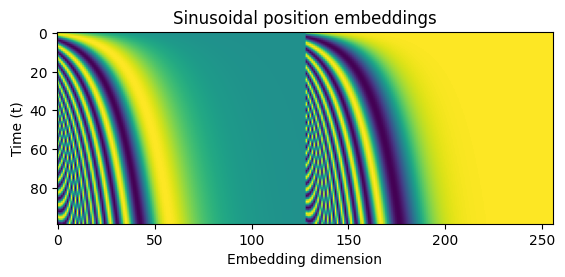

In [12]:
pos_encs = []

for i in range(1, 100):
	t = torch.tensor([i])
	pos_enc = positional_encoding(t, EMBEDDING_DIM)
	pos_encs.append(pos_enc.squeeze())

pos_encs = torch.stack(pos_encs)

fig = plt.figure()
plt.imshow(pos_encs.cpu().numpy())
plt.xlabel("Embedding dimension")
plt.ylabel("Time (t)")
plt.title("Sinusoidal position embeddings")
plt.show()

### Optimizers

We will define the optimizer and learning rate for the model. We will use the Adam optimizer with a learning rate of 1e-4.

In [13]:
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)

### Loss function

We will use a mean squared error loss function to train the model.

In [14]:
criterion = torch.nn.MSELoss()

### Data loaders

We now define the data loaders for the training and test datasets. We will use a batch size of 64 as defined by the `batch_size` parameter. We will also set the `shuffle` parameter to `True` for the training data loader to shuffle the training dataset.

In [15]:
from torch.utils.data import DataLoader

BATCH_SIZE = 128

train_loader = DataLoader(dataset=trainset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(dataset=valset, batch_size=BATCH_SIZE, shuffle=True)

## Training procedure

We now define an instance of the `Diffusion` class with 1000 noise steps for training the model.

In [16]:
IMAGE_SIZE = 28
NOISE_STEPS = 1000

diffusion = Diffusion(img_size=IMAGE_SIZE, noise_steps=NOISE_STEPS, device=device)

We now define a helper function `prepare_data` to prepare the data for training the model. The function takes a clean image from the dataset, and returns the noisy image, time step, and the noise added to the image. The former two are used as input to the model, and the latter is used as the target output.

In [17]:
def prepare_data(image, device=device):
    
    # Generate noise and timesteps and apply diffusion
    batch_size = image.shape[0]
    t = diffusion.sample_timesteps(batch_size)
    image = image.to(device)
    x_t, noise = diffusion.noise_images(image, t)
    t = positional_encoding(t.unsqueeze(1), EMBEDDING_DIM) # Here unsqueeze required for broadcasting to the positional encoding (for parallel processing)

    # Move to device
    x_t = x_t.to(device)
    t = t.to(device)
    noise = noise.to(device)

    return x_t, t, noise

We now define the training loop for the DDPM model for generating MNIST digits from a noise image. We will train the model for 20 epochs defined by the `EPOCHS` parameter.

Once every epoch, we will print the losses, time taken for the epoch, and also visualize the generated images.



Epoch 1 / 20
__________


Batch 1 / 469: Train loss: 1.3162
Batch 101 / 469: Train loss: 0.1520
Batch 201 / 469: Train loss: 0.1031
Batch 301 / 469: Train loss: 0.0641
Batch 401 / 469: Train loss: 0.0697
----------
Epoch 1/20 : Train loss: 0.1292, Val loss: 0.0537
Time taken: 0:00:42.137073


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:22<00:00, 43.49it/s]


Class_label 6


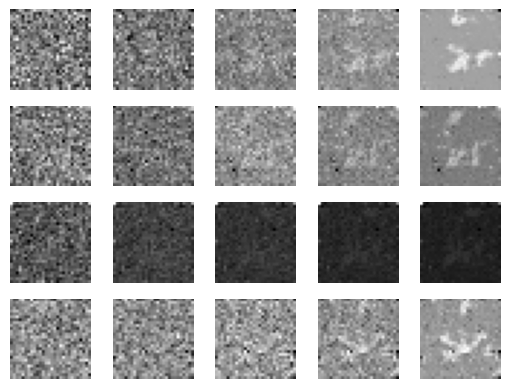



Epoch 2 / 20
__________
Batch 1 / 469: Train loss: 0.0575
Batch 101 / 469: Train loss: 0.0578
Batch 201 / 469: Train loss: 0.0465
Batch 301 / 469: Train loss: 0.0313
Batch 401 / 469: Train loss: 0.0483
----------
Epoch 2/20 : Train loss: 0.0472, Val loss: 0.0406
Time taken: 0:00:49.684875


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:16<00:00, 62.08it/s]


Class_label 7


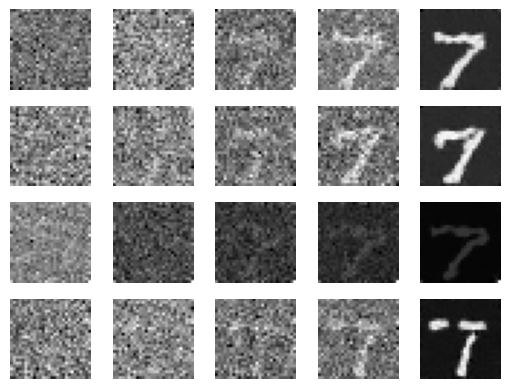



Epoch 3 / 20
__________
Batch 1 / 469: Train loss: 0.0463
Batch 101 / 469: Train loss: 0.0389
Batch 201 / 469: Train loss: 0.0337
Batch 301 / 469: Train loss: 0.0480
Batch 401 / 469: Train loss: 0.0355
----------
Epoch 3/20 : Train loss: 0.0389, Val loss: 0.0369
Time taken: 0:00:56.645231


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:18<00:00, 53.26it/s]


Class_label 9


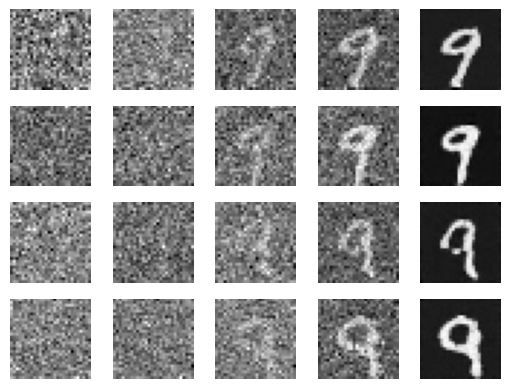



Epoch 4 / 20
__________
Batch 1 / 469: Train loss: 0.0454
Batch 101 / 469: Train loss: 0.0437
Batch 201 / 469: Train loss: 0.0343
Batch 301 / 469: Train loss: 0.0412
Batch 401 / 469: Train loss: 0.0323
----------
Epoch 4/20 : Train loss: 0.0347, Val loss: 0.0325
Time taken: 0:00:46.882932


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:22<00:00, 43.96it/s]


Class_label 7


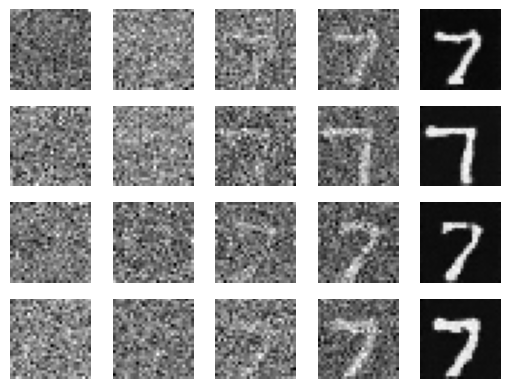



Epoch 5 / 20
__________
Batch 1 / 469: Train loss: 0.0279
Batch 101 / 469: Train loss: 0.0346
Batch 201 / 469: Train loss: 0.0369
Batch 301 / 469: Train loss: 0.0259
Batch 401 / 469: Train loss: 0.0305
----------
Epoch 5/20 : Train loss: 0.0322, Val loss: 0.0306
Time taken: 0:00:44.053882


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:21<00:00, 47.30it/s]


Class_label 3


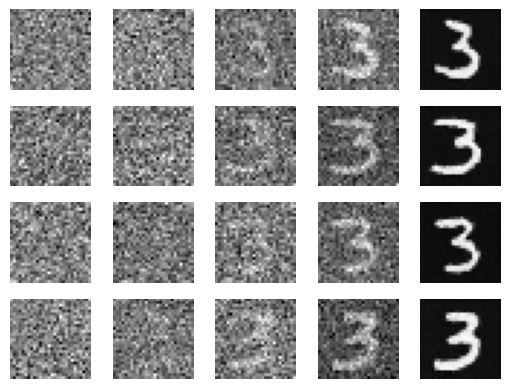



Epoch 6 / 20
__________
Batch 1 / 469: Train loss: 0.0373
Batch 101 / 469: Train loss: 0.0243
Batch 201 / 469: Train loss: 0.0279
Batch 301 / 469: Train loss: 0.0244
Batch 401 / 469: Train loss: 0.0334
----------
Epoch 6/20 : Train loss: 0.0309, Val loss: 0.0298
Time taken: 0:00:56.512023


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 62.67it/s]


Class_label 0


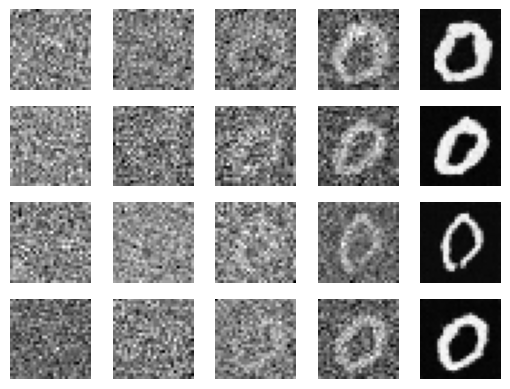



Epoch 7 / 20
__________
Batch 1 / 469: Train loss: 0.0313
Batch 101 / 469: Train loss: 0.0311
Batch 201 / 469: Train loss: 0.0312
Batch 301 / 469: Train loss: 0.0297
Batch 401 / 469: Train loss: 0.0260
----------
Epoch 7/20 : Train loss: 0.0291, Val loss: 0.0283
Time taken: 0:00:49.979904


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:22<00:00, 43.60it/s]


Class_label 3


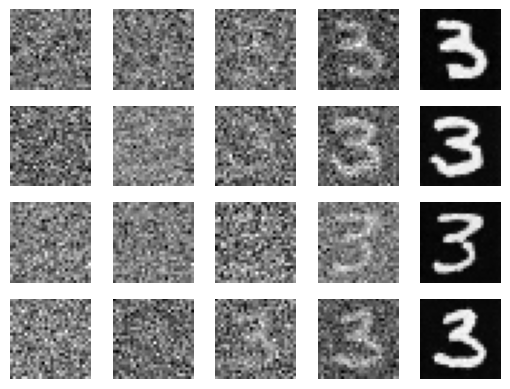



Epoch 8 / 20
__________
Batch 1 / 469: Train loss: 0.0279
Batch 101 / 469: Train loss: 0.0327
Batch 201 / 469: Train loss: 0.0309
Batch 301 / 469: Train loss: 0.0252
Batch 401 / 469: Train loss: 0.0233
----------
Epoch 8/20 : Train loss: 0.0282, Val loss: 0.0277
Time taken: 0:00:41.111055


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:22<00:00, 43.62it/s]


Class_label 4


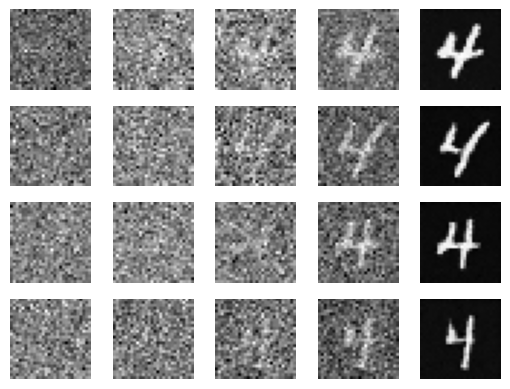



Epoch 9 / 20
__________
Batch 1 / 469: Train loss: 0.0266
Batch 101 / 469: Train loss: 0.0273
Batch 201 / 469: Train loss: 0.0340
Batch 301 / 469: Train loss: 0.0281
Batch 401 / 469: Train loss: 0.0302
----------
Epoch 9/20 : Train loss: 0.0276, Val loss: 0.0269
Time taken: 0:00:55.066919


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:13<00:00, 75.48it/s]


Class_label 6


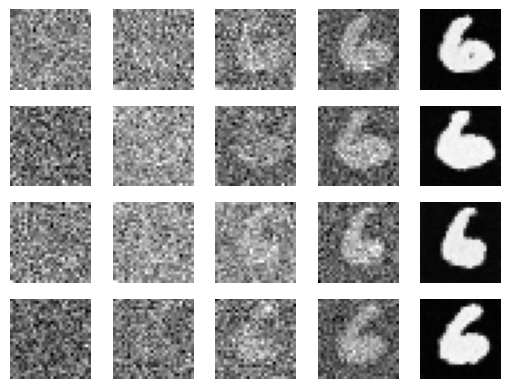



Epoch 10 / 20
__________
Batch 1 / 469: Train loss: 0.0308
Batch 101 / 469: Train loss: 0.0249
Batch 201 / 469: Train loss: 0.0292
Batch 301 / 469: Train loss: 0.0286
Batch 401 / 469: Train loss: 0.0276
----------
Epoch 10/20 : Train loss: 0.0266, Val loss: 0.0266
Time taken: 0:00:56.204816


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:23<00:00, 43.29it/s]


Class_label 5


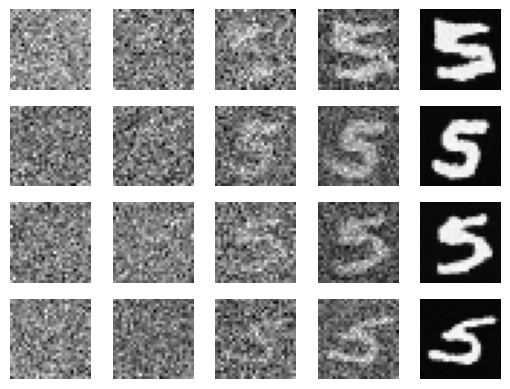



Epoch 11 / 20
__________
Batch 1 / 469: Train loss: 0.0307
Batch 101 / 469: Train loss: 0.0229
Batch 201 / 469: Train loss: 0.0240
Batch 301 / 469: Train loss: 0.0284
Batch 401 / 469: Train loss: 0.0283
----------
Epoch 11/20 : Train loss: 0.0262, Val loss: 0.0258
Time taken: 0:00:42.012159


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:23<00:00, 43.15it/s]


Class_label 3


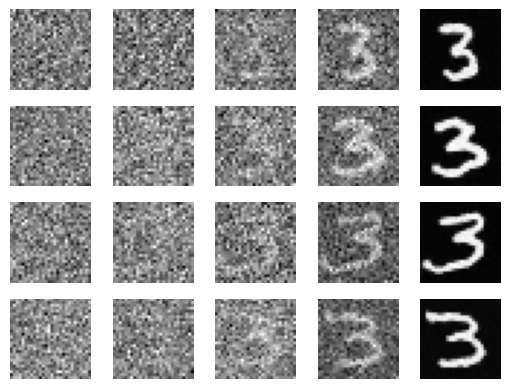



Epoch 12 / 20
__________
Batch 1 / 469: Train loss: 0.0251
Batch 101 / 469: Train loss: 0.0300
Batch 201 / 469: Train loss: 0.0241
Batch 301 / 469: Train loss: 0.0286
Batch 401 / 469: Train loss: 0.0279
----------
Epoch 12/20 : Train loss: 0.0266, Val loss: 0.0254
Time taken: 0:00:49.328720


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:15<00:00, 62.67it/s]


Class_label 6


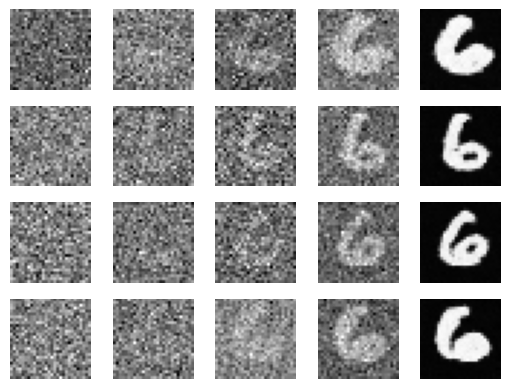



Epoch 13 / 20
__________
Batch 1 / 469: Train loss: 0.0263
Batch 101 / 469: Train loss: 0.0251
Batch 201 / 469: Train loss: 0.0280
Batch 301 / 469: Train loss: 0.0247
Batch 401 / 469: Train loss: 0.0217
----------
Epoch 13/20 : Train loss: 0.0256, Val loss: 0.0254
Time taken: 0:00:56.529866


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:19<00:00, 52.03it/s]


Class_label 6


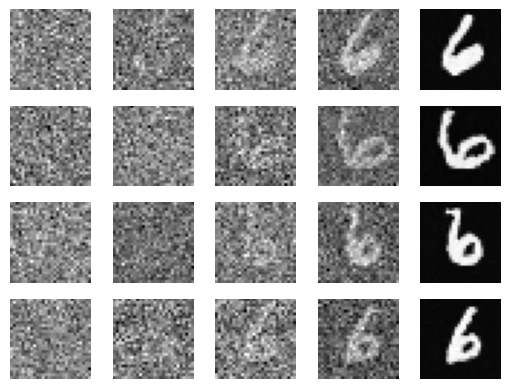



Epoch 14 / 20
__________
Batch 1 / 469: Train loss: 0.0278
Batch 101 / 469: Train loss: 0.0222
Batch 201 / 469: Train loss: 0.0238
Batch 301 / 469: Train loss: 0.0225
Batch 401 / 469: Train loss: 0.0306
----------
Epoch 14/20 : Train loss: 0.0255, Val loss: 0.0247
Time taken: 0:00:46.625799


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:22<00:00, 43.54it/s]


Class_label 7


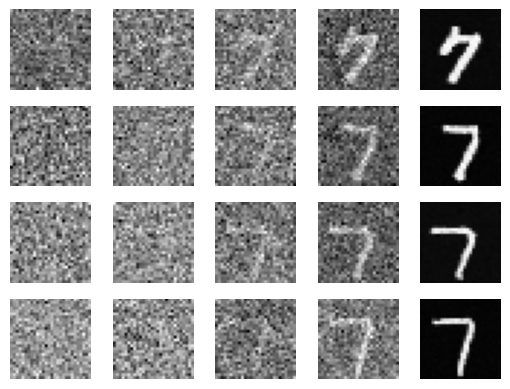



Epoch 15 / 20
__________
Batch 1 / 469: Train loss: 0.0282
Batch 101 / 469: Train loss: 0.0256
Batch 201 / 469: Train loss: 0.0259
Batch 301 / 469: Train loss: 0.0193
Batch 401 / 469: Train loss: 0.0201
----------
Epoch 15/20 : Train loss: 0.0249, Val loss: 0.0247
Time taken: 0:00:43.811711


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:22<00:00, 45.24it/s]


Class_label 4


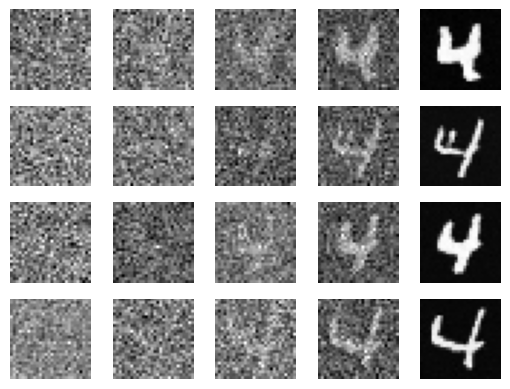



Epoch 16 / 20
__________
Batch 1 / 469: Train loss: 0.0291
Batch 101 / 469: Train loss: 0.0262
Batch 201 / 469: Train loss: 0.0221
Batch 301 / 469: Train loss: 0.0253
Batch 401 / 469: Train loss: 0.0200
----------
Epoch 16/20 : Train loss: 0.0246, Val loss: 0.0263
Time taken: 0:00:56.572652


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:13<00:00, 75.69it/s]


Class_label 9


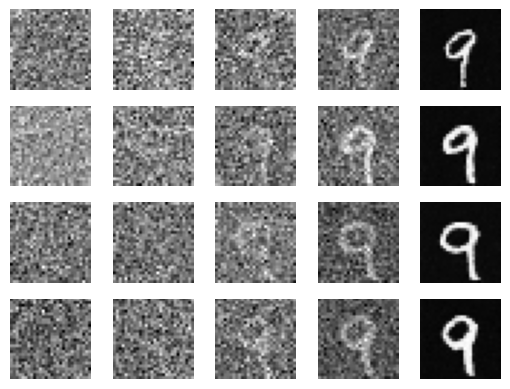



Epoch 17 / 20
__________
Batch 1 / 469: Train loss: 0.0254
Batch 101 / 469: Train loss: 0.0274
Batch 201 / 469: Train loss: 0.0248
Batch 301 / 469: Train loss: 0.0250
Batch 401 / 469: Train loss: 0.0278
----------
Epoch 17/20 : Train loss: 0.0244, Val loss: 0.0241
Time taken: 0:00:51.589050


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:22<00:00, 43.77it/s]


Class_label 3


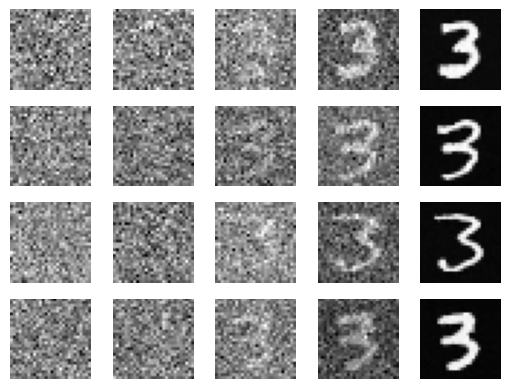



Epoch 18 / 20
__________
Batch 1 / 469: Train loss: 0.0218
Batch 101 / 469: Train loss: 0.0228
Batch 201 / 469: Train loss: 0.0251
Batch 301 / 469: Train loss: 0.0236
Batch 401 / 469: Train loss: 0.0251
----------
Epoch 18/20 : Train loss: 0.0242, Val loss: 0.0227
Time taken: 0:00:41.144192


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:23<00:00, 43.42it/s]


Class_label 3


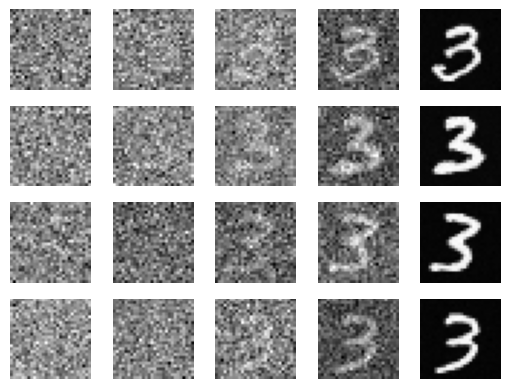



Epoch 19 / 20
__________
Batch 1 / 469: Train loss: 0.0232
Batch 101 / 469: Train loss: 0.0215
Batch 201 / 469: Train loss: 0.0266
Batch 301 / 469: Train loss: 0.0261
Batch 401 / 469: Train loss: 0.0245
----------
Epoch 19/20 : Train loss: 0.0241, Val loss: 0.0236
Time taken: 0:00:53.367302


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:13<00:00, 73.44it/s]


Class_label 4


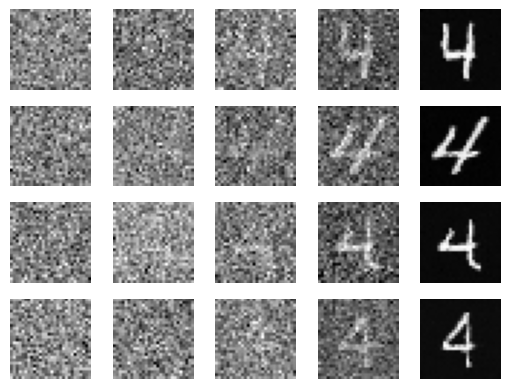



Epoch 20 / 20
__________
Batch 1 / 469: Train loss: 0.0199
Batch 101 / 469: Train loss: 0.0259
Batch 201 / 469: Train loss: 0.0286
Batch 301 / 469: Train loss: 0.0203
Batch 401 / 469: Train loss: 0.0241
----------
Epoch 20/20 : Train loss: 0.0239, Val loss: 0.0235
Time taken: 0:00:56.629086


UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:23<00:00, 43.33it/s]


Class_label 3


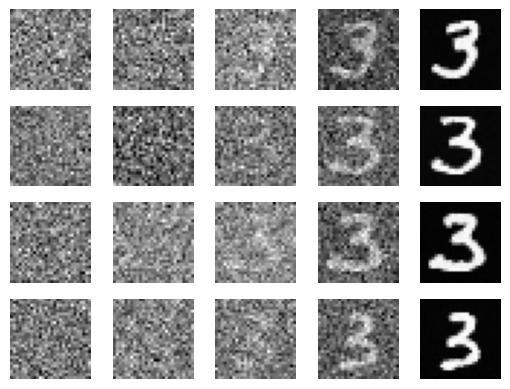

In [18]:
EPOCHS = 20

# Import the packages required for checking the time taken for each epoch
import time
from datetime import timedelta
import numpy as np

train_loss = []
val_loss = []

for epoch in range(EPOCHS):

    # Record the start time of the epoch
    start_time = time.time()

    num_batches = len(train_loader)

    print("\n")
    print(f"Epoch {epoch+1} / {EPOCHS}")
    print("_" * 10)

    model.train(True)

    running_loss = 0.0
    for batch_idx, (image, class_labels) in enumerate(train_loader, start=0):

        # Prepare data
        x_t, t, noise = prepare_data(image)
        class_labels = class_labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Classifier-free-guidance
        if np.random.rand()<0.1: # 10% of the time
            class_labels = None

        # Forward + reverse + gradients
        outputs = model(x_t, t, class_labels)
        loss = criterion(outputs, noise)
        loss.backward()
        optimizer.step()

        # Print loss after certian number of batches
        if batch_idx % 100 == 0:
            print(
                f"Batch {batch_idx+1} / {num_batches}: Train loss: {loss.item():.4f}"
            )

        # Update the running loss
        running_loss += loss.item()

    # Store the training loss for this epoch
    train_loss.append(running_loss / len(train_loader))

    # Validation
    # Set the model to evaluation mode
    model.eval()

    with torch.no_grad():
        running_loss = 0.0
        for batch_idx, (image, class_labels) in enumerate(val_loader):
            # Prepare data
            x_t, t, noise = prepare_data(image)
            class_labels = class_labels.to(device)

            # Forward pass
            outputs = model(x_t, t, class_labels)
            loss = criterion(outputs, noise)

            # Update the running loss
            running_loss += loss.item()

        # Store the validation loss for this epoch
        val_loss.append(running_loss / len(val_loader))

    # Record the end time of the epoch
    end_time = time.time()

    # Print the loss for this epoch
    print("-" * 10)
    print(
        f"Epoch {epoch+1}/{EPOCHS} : Train loss: {train_loss[-1]:.4f}, Val loss: {val_loss[-1]:.4f}"
    )
    print(f"Time taken: {timedelta(seconds=end_time - start_time)}")

    # Generate some images from noise every epoch
    num_images = 4

    # Create a random class label for generating `num_images` images
    class_labels = torch.ones((num_images,)) * torch.randint(0, 10, (1,))
    class_labels = class_labels.long().to(device)

    generated_images = diffusion.sample_test_images(
        model,
        n=num_images,
        n_channels=1,
        position_encoding_dim=EMBEDDING_DIM,
        position_encoding_function=positional_encoding,
        save_every=200,
        class_labels=class_labels,
        cfg=True,
        cfg_guidance_strength=3,
    )

    # Print class label
    print("Class_label", class_labels.cpu().numpy().squeeze()[0])

    # Plot generated images
    fig = plt.figure()
    for inx in range(num_images):
        image_reverse_diff_traj = generated_images[inx]


        for i in range(len(image_reverse_diff_traj)):
            plt.subplot(num_images, len(image_reverse_diff_traj), inx * len(image_reverse_diff_traj) + i + 1)
            plt.imshow(image_reverse_diff_traj[i].permute(1, 2, 0).cpu().numpy(), cmap="gray")
            plt.axis("off")
    plt.show()


### Sample images

Using the trained model, we will now generate some sample images of the specified digit.

UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:22<00:00, 43.66it/s]


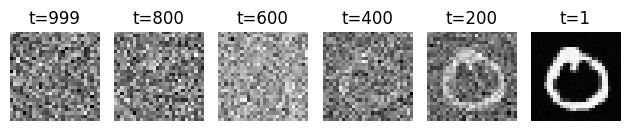

UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:22<00:00, 43.71it/s]


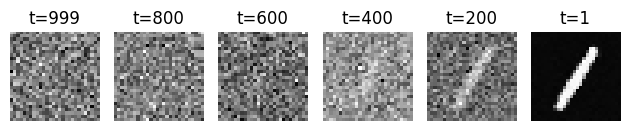

UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:20<00:00, 49.42it/s]


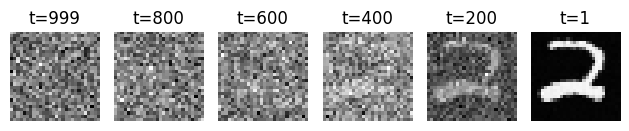

UNet inference: 100%|███████████████████████████████████████████████████████████████████████████▉| 999/1000 [00:12<00:00, 76.91it/s]


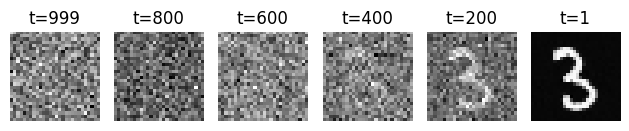

In [20]:
# Set the model to evaluation mode
model.eval()

# Denromalize the image
def denormalize_noise(image):
    image = image.permute(1, 2, 0).cpu().numpy()
    image = image * 0.5 + 0.5
    return image


# Number of images to sample
num_images = 4 

# Fixed noise for sampling
fixed_noise = torch.randn((1, 1, IMAGE_SIZE, IMAGE_SIZE))
class_labels = torch.arange(0, num_images)[..., None].to(device)
save_time_steps = [999, 800, 600, 400, 200, 1] # Sample images at these time steps

for i in range(num_images):
    processed_images = diffusion.sample_test_images(
        model,
        n=1,
        n_channels=1,
        fixed_noise=fixed_noise,
        position_encoding_dim=EMBEDDING_DIM,
        position_encoding_function=positional_encoding,
        class_labels=class_labels[i],
        save_time_steps=save_time_steps,
        cfg=True,
        cfg_guidance_strength=3,
    )  # Outputs a tensor of shape (1, t_noise, n_channels, 28, 28) where t_noise is the number of noise steps for plotting

    fig, axs = plt.subplots(1, len(save_time_steps))
    for j in range(len(save_time_steps)):
        axs[j].imshow(denormalize_noise(processed_images[0, j]), cmap="gray")
        # axs[j].set_title(f"t={j}", fontsize=70)
        axs[j].set_title(f"t={save_time_steps[j]}")
        axs[j].axis("off")
    plt.tight_layout()
    plt.show()

### Plot losses

We now plot the losses for the training and test datasets.

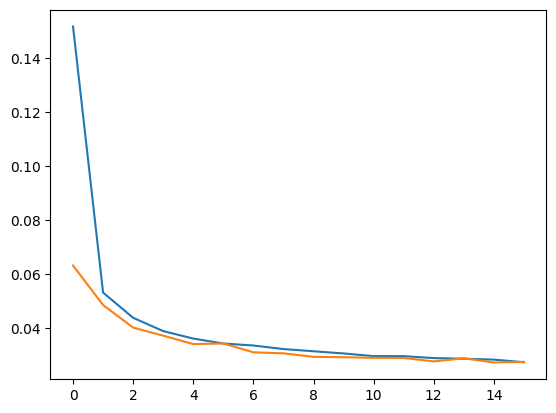

In [ ]:
plt.plot(train_loss, label="Train loss")
plt.plot(val_loss, label="Val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()